In [ ]:
#!pip install statsmodels prophet==1.1.5 cmdstanpy tqdm ipywidgets numpy<2
#!pip install langchain faiss-cpu sentence-transformers groq plotly

### Synthetic Supply-Chain Data Generator

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import plotly
import plotly.express as px
import plotly.graph_objects as go
import tqdm
import warnings
import datetime

from google.colab import output
from tqdm import tqdm
from google.colab import userdata
from datetime import datetime, timedelta
from IPython.display import display, Markdown

warnings.filterwarnings('ignore')
random.seed(42)
np.random.seed(42)

GROQ_API_KEY = userdata.get('GROQ_API_KEY')

os.makedirs('synth_data',exist_ok=True)

display(Markdown('## Generating Synthetic Supply-Chain Data'))

#Parameters
n_skus = 25
n_suppliers = 6
n_warehouses = 3
start_date = datetime.today() - timedelta(days=365) # 1 Year history
end_date = datetime.today() + timedelta(days=120) #120 days future horizon
date_range = pd.date_range(start = start_date, end=end_date, freq='D')

sku_ids = [f'SKU-{1000+i}' for i in range(n_skus)]
suppliers = [f'SUPP-{200+i}' for i in range(n_suppliers)]
warehouses = [f'WH-{1+i}' for i in range(n_warehouses)]
regions = ['North','Europe','APAC']

#1) Daily Demand per SKU (base + seasonality + noise)
demand_rows = []

for sku in sku_ids:
  base = random.randint(2,50) #base daily demand
  weekly_seasonability = (np.sin(np.linspace(0, 3*np.pi, len(date_range)))+1)* base * 0.15
  trend = np.linspace(0, base*0.2, len(date_range))
  noise = np.random.poisson(lam=max(0.5,base*0.5), size=len(date_range))
  demand = np.maximum(0, base+weekly_seasonability + trend + noise).astype(int)
  for dt, d in zip(date_range, demand):
    demand_rows.append({
        'date':dt.date(),
        'sku':sku,
        'demand':int(d)
    })


df_demand = pd.DataFrame(demand_rows)
df_demand.to_csv('synth_data/daily_demand.csv',index=False)

#print('Everything imported successfully!!!')
df_demand.head()



## Generating Synthetic Supply-Chain Data

,date,sku,demand
0,2024-11-13,SKU-1000,72
1,2024-11-14,SKU-1000,64
2,2024-11-15,SKU-1000,70
3,2024-11-16,SKU-1000,74
4,2024-11-17,SKU-1000,64


### Purchase Orders

In [ ]:
po_rows = []
po_id = 10000
for sku in sku_ids:
  #generate 10-18 POs per SKU across the period
  n_pos = random.randint(10,18)
  possible_dates = pd.date_range(start=start_date - timedelta(days=90),end=end_date,freq='7D')
  chosen_dates = np.random.choice(possible_dates, size=n_pos, replace=False)
  for order_date in chosen_dates:
    supplier = random.choice(suppliers)
    qty = int(np.clip(np.random.normal(loc=200,scale=80), 50,2000))
    #Lead time depends on supplier, random but stable
    base_lead = random.randint(3,20)
    #create expected arrival and actual arrival(later we simulate delays)
    expected_arrival = (pd.Timestamp(order_date) + timedelta(days=base_lead)).date()
    #Actual arrival will be computed in shipments (may delay)
    po_rows.append({
        'po_id':f'PO-{po_id}',
        'sku':sku,
        'supplier':supplier,
        'order_date':pd.Timestamp(order_date).date(),
        'qty_ordered':qty,
        'expected_lead_days':base_lead,
        'expected_arrival':expected_arrival

    })
    po_id += 1

df_pos = pd.DataFrame(po_rows).sort_values(['order_date'])
df_pos.to_csv('synth_data/purchase_orders.csv',index=False)
df_pos.head()

,po_id,sku,supplier,order_date,qty_ordered,expected_lead_days,expected_arrival
229,PO-10229,SKU-1017,SUPP-205,2024-08-15,241,15,2024-08-30
64,PO-10064,SKU-1004,SUPP-205,2024-08-15,280,12,2024-08-27
281,PO-10281,SKU-1020,SUPP-203,2024-08-15,197,4,2024-08-19
20,PO-10020,SKU-1001,SUPP-203,2024-08-15,263,11,2024-08-26
117,PO-10117,SKU-1008,SUPP-200,2024-08-22,141,4,2024-08-26


### Shipment Logs (simulate actual arrivals with delays)

In [ ]:
shipment_rows = []
shipment_id = 8000
for _, po in df_pos.iterrows():
  #simulate shipment departure 1-3 days after order
  depart_delta = int(np.clip(np.random.normal(2,1), 0, 7))
  depart_date = pd.to_datetime(po['order_date']) + timedelta(days=depart_delta)
  ##Simlate delay: small chance of large disruption
  base_lead = int(po['expected_lead_days'])
  #random noise around lead
  noise = max(0, int(np.random.normal(0,2)))
  disruption = 0
  if random.random() < 0.05:
    disruption = random.randint(6, 18)
  actual_lead = base_lead + noise + disruption
  arrival_date = depart_date + timedelta(days=actual_lead)
  #Shipping mode and port
  mode = random.choice(['Ocean', 'Air','Truck'])
  port = random.choice(['Port A','Port B','Port C','Port D'])
  shipment_rows.append({
      'shipment_id':f'SHIP-{shipment_id}',
      'po_id':po['po_id'], # Changed from po['sku'] to po['po_id']
      'supplier':po['supplier'],
      'depart_date':depart_date.date(),
      'arrival_date':arrival_date.date(),
      'mode':mode,
      'port':port,
      'actual_lead_days':actual_lead,
      'qty':po['qty_ordered']
  })
  shipment_id += 1

df_shipments = pd.DataFrame(shipment_rows).sort_values(['arrival_date'])
df_shipments.to_csv('synth_data/shipments.csv',index=False)
df_shipments.head()

,shipment_id,po_id,supplier,depart_date,arrival_date,mode,port,actual_lead_days,qty
2,SHIP-8002,PO-10281,SUPP-203,2024-08-18,2024-08-22,Truck,Port D,4,197
7,SHIP-8007,PO-10312,SUPP-205,2024-08-22,2024-08-26,Air,Port C,4,217
3,SHIP-8003,PO-10020,SUPP-203,2024-08-17,2024-08-28,Truck,Port C,11,263
4,SHIP-8004,PO-10117,SUPP-200,2024-08-24,2024-08-28,Ocean,Port A,4,141
0,SHIP-8000,PO-10229,SUPP-205,2024-08-15,2024-08-30,Air,Port B,15,241


### Inventory Snapshots (daily per warehouse per SKU) -- simple simulation

In [ ]:
#Initialize inventory on start date
inventory_rows = []
#start inventory: random small stock per SKU per warehouse
start_inventory = {(sku,wh): random.randint(50,500) for sku in sku_ids for wh in warehouses}

#build a map of inbound arrivals by date and sku(distirbute across warehouses randomly)
arrivals = {}
for _, sh in df_shipments.iterrows():
  date = pd.to_datetime(sh['arrival_date']).date()
  sku = sh['po_id'] # Changed from sh['sku'] to sh['po_id']
  qty = int(sh['qty'])
  #randomly allocate to warehouses proportionally
  assigned_wh = random.choice(warehouses)
  arrivals.setdefault((date, sku, assigned_wh), 0)
  arrivals[(date, sku, assigned_wh)] += qty

#Simulate daily inventory by subtracting demand(split demand accross warehouses)
for dt in pd.date_range(start=start_date, end=end_date, freq='D'):
  for sku in sku_ids:
    #total demand for date for this sku
    drow = df_demand[(df_demand['date'] == dt.date()) & (df_demand['sku'] == sku)]
    demand_today = int(drow['demand'].sum()) if not drow.empty else 0
    #Split demand across warehouses
    for wh in warehouses:
      key = (sku,wh)
      prev = start_inventory.get(key,200)
      #inbound arrivals
      inbound = arrivals.get((dt.date(),sku,wh),0)
      #allocate proportional share of demand(simple)
      demand_share = int(demand_today / len(warehouses))
      new_inv = max(0, prev+inbound - demand_share)
      inventory_rows.append({
          'date':dt.date(),
          'sku':sku,
          'warehouse':wh,
          'inventory':int(new_inv),
          'inbound':int(inbound),
          'demand':int(demand_share),
          })
      #update for the next day
      start_inventory[key] = new_inv

df_inventory = pd.DataFrame(inventory_rows)
df_inventory.to_csv('synth_data/inventory_snapshots.csv',index=False)
df_inventory.head()

,date,sku,warehouse,inventory,inbound,demand
0,2024-11-13,SKU-1000,WH-1,289,0,24
1,2024-11-13,SKU-1000,WH-2,229,0,24
2,2024-11-13,SKU-1000,WH-3,443,0,24
3,2024-11-13,SKU-1001,WH-1,324,0,4
4,2024-11-13,SKU-1001,WH-2,288,0,4


### Market Indicator Time-Series

In [ ]:
market = []
for dt in pd.date_range(start=start_date, end=end_date, freq='D'):
  #Shipping index with some trend and noise and occasional spikes
  base = 100 + 0.5 * (dt - start_date).days
  spike = 0
  if random.random() < 0.02:
    spike = random.uniform(5,25)
  val = base + np.sin((dt.dayofyear / 365.0) * 2*np.pi) * 6 + np.random.normal(0,1.5) + spike
  fuel = 2.5 + np.random.normal(0,0.05) + (0.001 * (dt - start_date).days)
  market.append({
      'date':dt.date(),
      'shipping_index':float(round(val,2)),
      'fuel_cost':float(round(fuel,3))})


df_market = pd.DataFrame(market)
df_market.to_csv('synth_data/market_indicators.csv',index=False)
df_market.head()

,date,shipping_index,fuel_cost
0,2024-11-13,96.23,2.463
1,2024-11-14,95.48,2.463
2,2024-11-15,94.52,2.555
3,2024-11-16,100.42,2.413
4,2024-11-17,98.53,2.445


## EDA

## Files Generated: 

- `shipments.csv`

- `market_indicators.csv`

- `inventory_snapshots.csv`

- `purchase_orders.csv`

- `daily_demand.csv`

### Sample: Demand and Inventory for a sample SKU

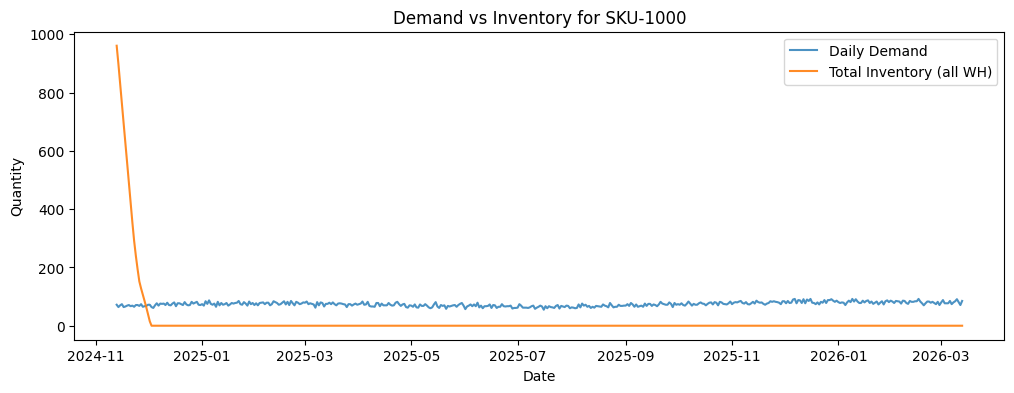

In [ ]:
display(Markdown('## Files Generated: '))
for f in os.listdir('synth_data'):
  display(Markdown(f'- `{f}`'))

display(Markdown('### Sample: Demand and Inventory for a sample SKU'))
sample_sku = sku_ids[0]
demand_sample = df_demand[df_demand['sku'] == sample_sku].set_index('date')['demand']
inv_sample = df_inventory[df_inventory['sku'] == sample_sku].groupby('date')['inventory'].sum()

plt.figure(figsize=(12,4))
plt.plot(demand_sample.index, demand_sample.values, label='Daily Demand', alpha=0.8)
plt.plot(inv_sample.index, inv_sample.values, label='Total Inventory (all WH)', alpha=0.9)
plt.title(f'Demand vs Inventory for {sample_sku}')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

### Shipment Lead TIme/ Delay Distribution

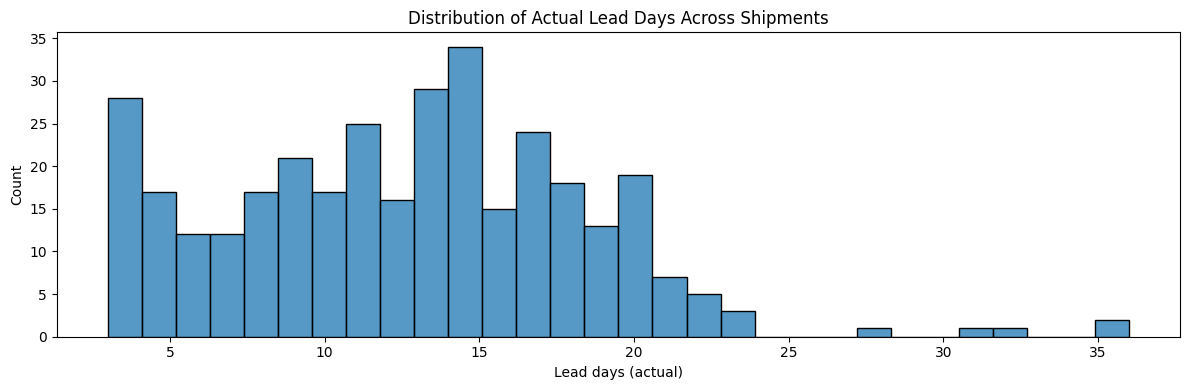

In [ ]:
plt.figure(figsize=(12,4))
sns.histplot(df_shipments['actual_lead_days'], kde=False, bins=30)
plt.xlabel('Lead days (actual)')
plt.title('Distribution of Actual Lead Days Across Shipments')
plt.tight_layout()
plt.show()

### Inventory Snapshot Distribution (sample day)

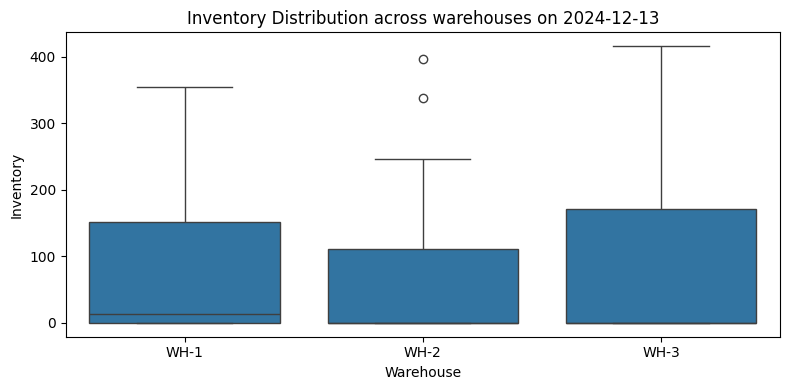

In [ ]:
sample_day = df_inventory['date'].unique()[30]
sample_inv = df_inventory[df_inventory['date'] == sample_day]
plt.figure(figsize=(8,4))
sns.boxplot(x='warehouse',y='inventory',data=sample_inv)
plt.title(f'Inventory Distribution across warehouses on {sample_day}')
plt.xlabel('Warehouse')
plt.ylabel('Inventory')
plt.tight_layout()
plt.show()

In [ ]:
display(Markdown('## Synthetic Dataset ready - saved under `synth_data`'))

## Synthetic Dataset ready - saved under `synth_data`

### **Data Cleaning, Transformation and KPI Computation**

In [ ]:
sns.set(style='whitegrid')

display(Markdown('## Data Cleaning & KPI Preperation'))

#Load all the synthetic data
df_demand = pd.read_csv('synth_data/daily_demand.csv',parse_dates=['date'])
df_pos = pd.read_csv('synth_data/purchase_orders.csv',parse_dates=['order_date','expected_arrival'])
df_ship = pd.read_csv('synth_data/shipments.csv',parse_dates=['depart_date','arrival_date'])
df_inv = pd.read_csv('synth_data/inventory_snapshots.csv',parse_dates=['date'])
df_market = pd.read_csv('synth_data/market_indicators.csv',parse_dates=['date'])

print(f'Data loaded successfully!!!\n \n Demand: {df_demand.shape} | POS: {df_pos.shape} | Shipments: {df_ship.shape} | Inventory: {df_inv.shape} | Market: {df_market.shape}')

## Data Cleaning & KPI Preperation

Data loaded successfully!!!
 
 Demand: (12150, 3) | POS: (337, 7) | Shipments: (337, 9) | Inventory: (36450, 6) | Market: (486, 3)


### Basic Cleanup Checks

Supply Chain KPIs & Insights


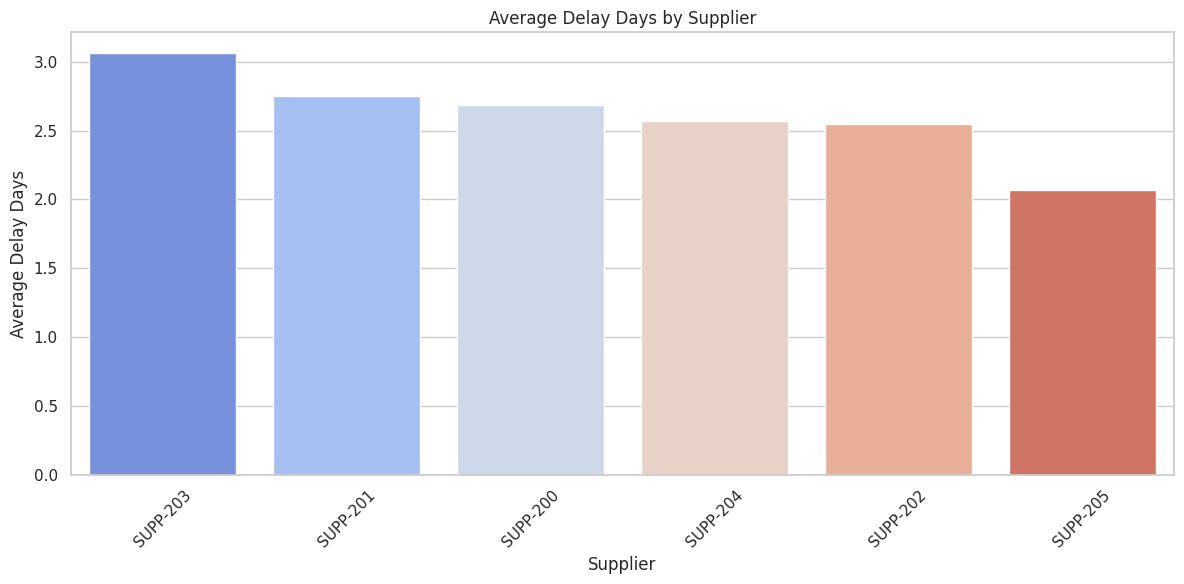

In [ ]:
from pandas.core.groupby import groupby
for df, name in [(df_demand, 'Demand'), (df_pos,'POs'), (df_ship, 'Shipments'), (df_inv, 'Inventory')]:
  missing = df.isnull().sum().sum()
  if missing > 0:
    print(f'{name} has {missing} missing values. Filling with defaults.')
    df.fillna(0, inplace=True)


#Merge shipments with POs (for delay and performance analysys)
merged = pd.merge(df_ship, df_pos[['po_id','expected_arrival']], on='po_id', how='left')
merged['delay_days'] = (merged['arrival_date'] - merged['expected_arrival']).dt.days
merged['delay_days'] = merged['delay_days'].clip(lower=0) # Changed clip lower bound from 8 to 0 as delays can be 0 or negative (early)
df_ship = merged


#Compute delay stats per supllier and port
supplier_perf = (
    df_ship.groupby('supplier')
    .agg(
        avg_delay=('delay_days','mean'),
        max_delay=('delay_days','max'),
        on_time_rate=('delay_days',lambda x: (x==0).mean()*100),
        shipments=('shipment_id','count')
    )
    .reset_index()
)

port_perf = (
    df_ship.groupby('port')
    .agg(
        avg_delay_days = ('delay_days','mean'),
        disruptions=('delay_days',lambda x: (x > 5).sum()),
    )
    .reset_index() # Added () to call the method
)

inv_stats = (
        df_inv.groupby('sku')
        .agg(
            avg_inventory=('inventory','mean'),
            stockouts=('inventory',lambda x: (x==0).sum()),
            total_days=('inventory','count'),
        )
        .reset_index()
    )


inv_stats['stockout_rate_%'] = 100 * inv_stats['stockouts'] / inv_stats['total_days']


#Demand fullfilment estimation
df_inv['fulfilled'] = np.minimum(df_inv['inventory'] + df_inv['inbound'], df_inv['demand'])
fulfillment_daily = (
    df_inv.groupby('date')['fulfilled'].sum() / df_inv.groupby('date')['demand'].sum()
).fillna(1)

#Visualize
print('Supply Chain KPIs & Insights')

#DElay by supplier
plt.figure(figsize=(12,6))
sns.barplot(data=supplier_perf.sort_values('avg_delay',ascending=False), x='supplier', y='avg_delay',palette='coolwarm')
plt.title('Average Delay Days by Supplier')
plt.xlabel('Supplier')
plt.ylabel('Average Delay Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Delay by Port

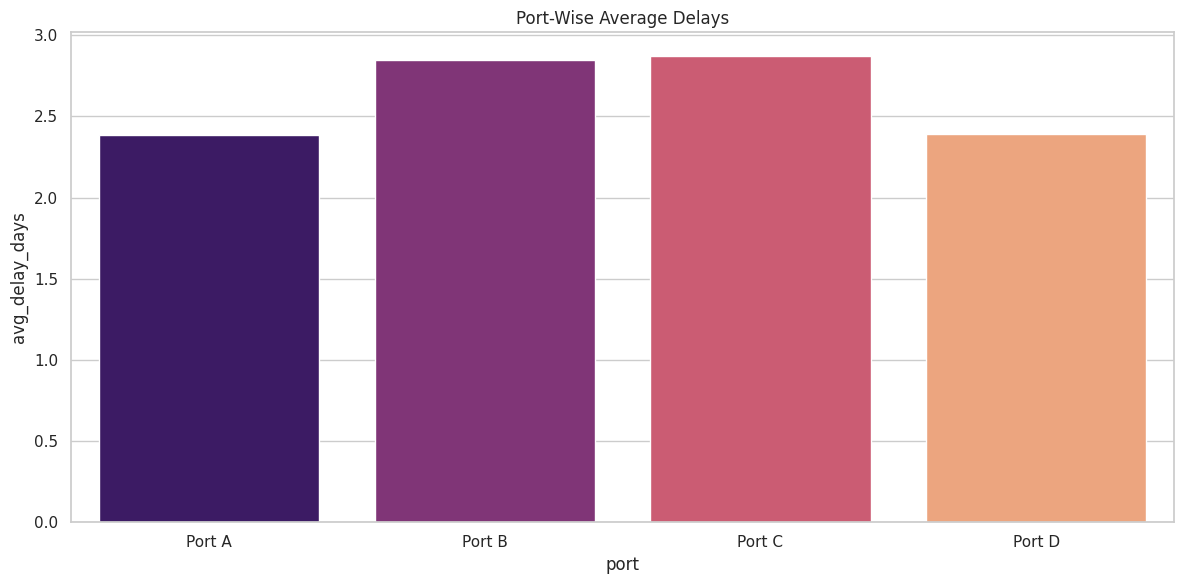

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=port_perf, x='port',y='avg_delay_days',palette='magma')
plt.title('Port-Wise Average Delays')
plt.tight_layout()
plt.show()

### Stockout Rates (Visual)

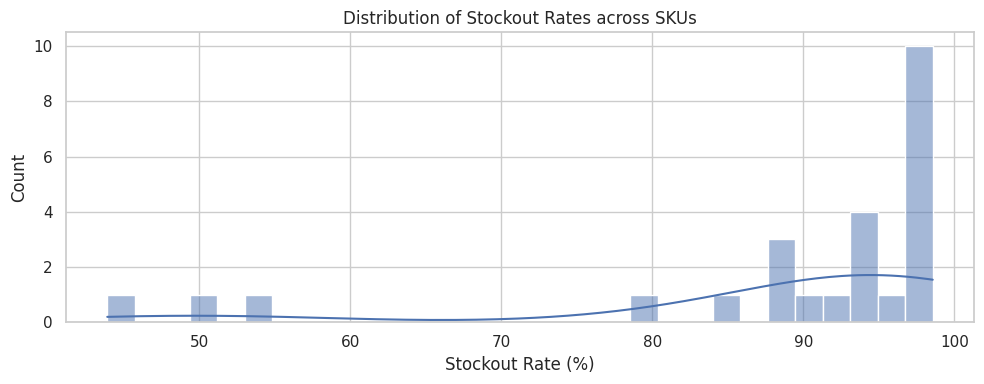

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(inv_stats['stockout_rate_%'], bins=30, kde=True)
plt.title('Distribution of Stockout Rates across SKUs')
plt.xlabel('Stockout Rate (%)')
plt.tight_layout()
plt.show()

### Demand fulfillment trend (Visual)


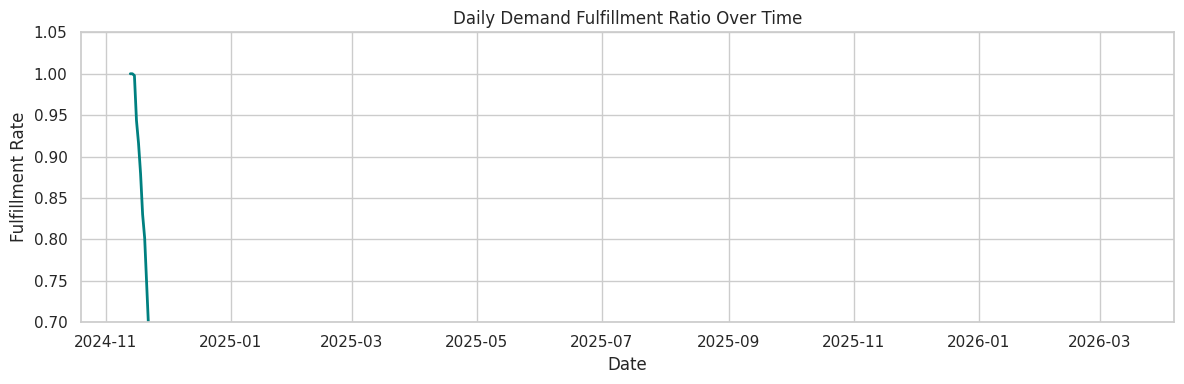

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(fulfillment_daily.index, fulfillment_daily.values, color='teal',lw=2)
plt.title('Daily Demand Fulfillment Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Fulfillment Rate')
plt.ylim(0.7,1.05)
plt.tight_layout()
plt.show()

###Market Correlation Quick View (Visual)

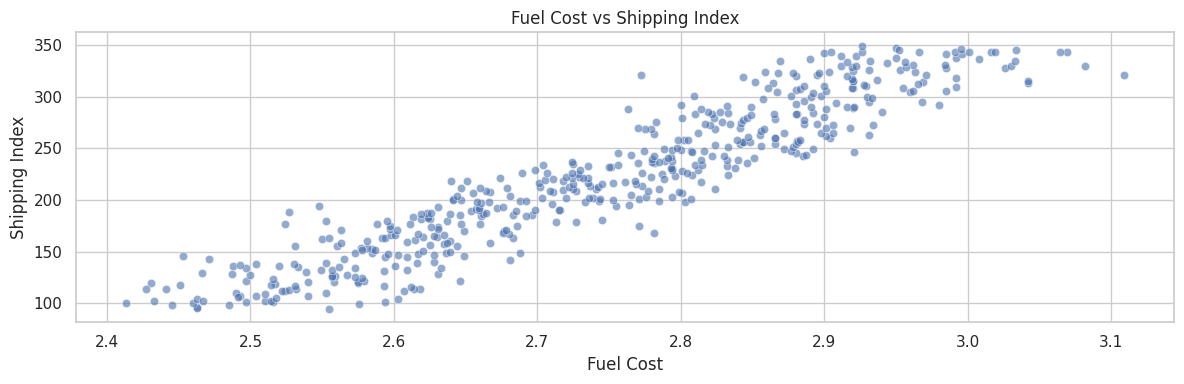


### 🧾 Summary Highlights:
- Suppliers with **high average delays** indicate weak reliability.
- Ports with repeated disruptions (>5 days delay) may require contingency routes.
- Stockout rates above 10% suggest poor inventory planning.
- Fulfillment ratio below 90% indicates service risk.
- Market correlation shows cost pressures may affect future logistics.


✅ **Data is now cleaned, transformed, and KPIs are computed for AI forecasting & RAG analysis!**

In [ ]:
plt.figure(figsize=(12,4))
sns.scatterplot(data=df_market,x='fuel_cost',y='shipping_index', cmap='coolwarm',alpha=0.6)
plt.title('Fuel Cost vs Shipping Index')
plt.xlabel('Fuel Cost')
plt.ylabel('Shipping Index')
plt.tight_layout()
plt.show()

display(Markdown("""
### 🧾 Summary Highlights:
- Suppliers with **high average delays** indicate weak reliability.
- Ports with repeated disruptions (>5 days delay) may require contingency routes.
- Stockout rates above 10% suggest poor inventory planning.
- Fulfillment ratio below 90% indicates service risk.
- Market correlation shows cost pressures may affect future logistics.
"""))

display(Markdown("✅ **Data is now cleaned, transformed, and KPIs are computed for AI forecasting & RAG analysis!**"))

## Predictive Forecasting + What-If Simulation Engine

In [ ]:
#!pip install --upgrade --force-reinstall numpy==1.26.4 prophet cmdstanpy


## DEmand forecasting and what-if simulation

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


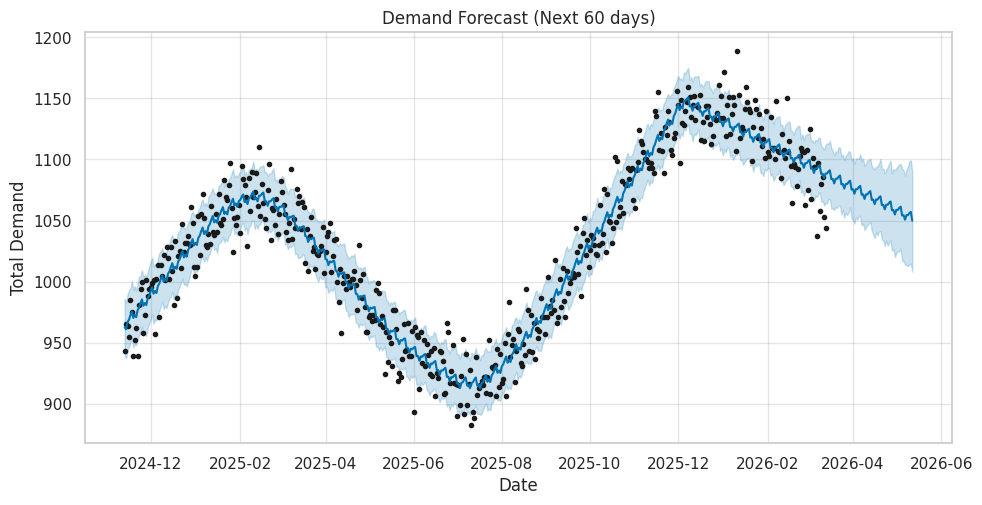

In [ ]:
from prophet import Prophet

#PRepare data for forecasting
display(Markdown('## DEmand forecasting and what-if simulation'))
df_demand = pd.read_csv('synth_data/daily_demand.csv',parse_dates=['date'])

#Aggregate total demand
daily_total = df_demand.groupby('date')['demand'].sum().reset_index()
daily_total.columns = ['ds','y']

#Now train the prophet model
model = Prophet(seasonality_mode='additive')
model.fit(daily_total)

#Make future dataframe for next 60 days
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

#Plot the forecast
fig1 = model.plot(forecast, xlabel='Date',ylabel='Total Demand', figsize=(10,5))
plt.title('Demand Forecast (Next 60 days)')
plt.show()

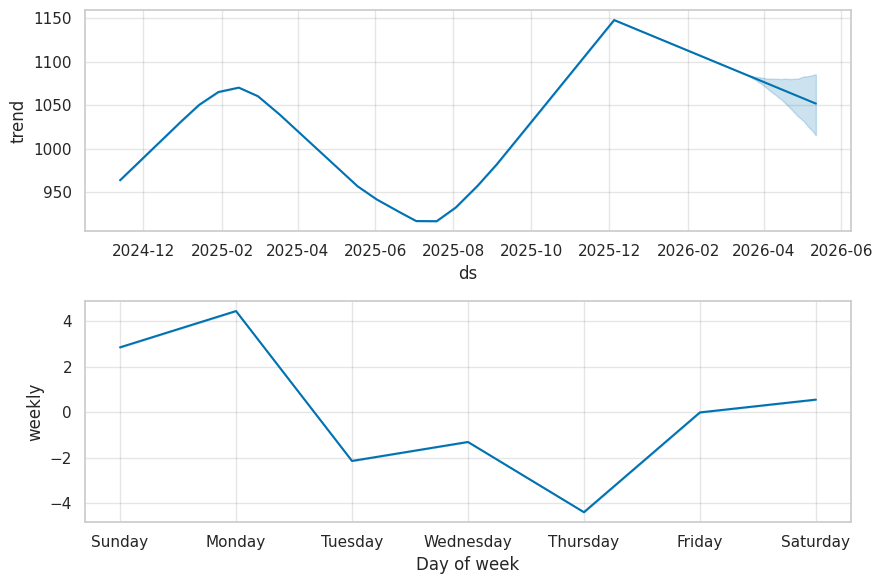

Forecast Ready!! Prophet model trained and predicts the next 60 days


In [ ]:
#Plot components
fig2 = model.plot_components(forecast)
plt.show()
print('Forecast Ready!! Prophet model trained and predicts the next 60 days')

### What-If Simulation Engine

Scenario: Port Shanghai experinces 7-day disruption
<function simulate_scenario at 0x7bcb38085da0>
---
Scenario: Fuel costs increase by 20%
<function simulate_scenario at 0x7bcb38085da0>
---
Scenario: Demand for SKU_10 surges by 25%
<function simulate_scenario at 0x7bcb38085da0>
---
Scenario: Suppler_3 faces labor shortage for 10 days
<function simulate_scenario at 0x7bcb38085da0>
---


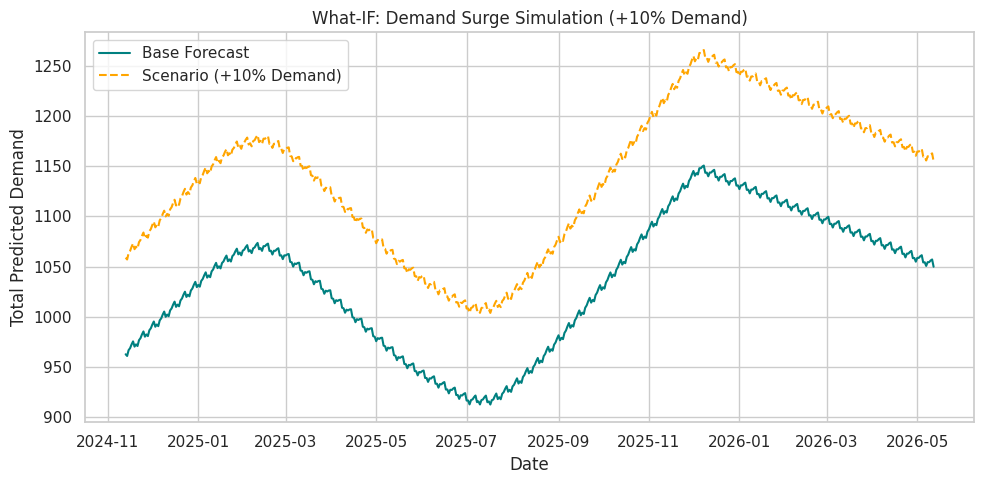

In [ ]:
def simulate_scenario(scenario:str):
  '''Use Groq LLM to interpret the users What-If questions and simulates effects.'''
  client = GROQ_API_KEY

  prompt = f'''
  You are supply chain AI simulation expert.
  Given the scenario below, estimate the expected effects.
  on demand, shipping delays and inventory health.
  Scenario: {scenario}

  Provide a structured summary like:
  - Demand impact (%)
  - Average shipping delay (days)
  - Inventory risk level (Low/Medium/High)
  - Business insight (short reasoning)
  '''

  response = client.chat.completion.create(
      messages=[{'role':'user','content':prompt}],
      model="llama-3.1-8b-instant",
      temperature=0.4,


  )
  result = response.choices[0].message.content
  return result

#Run an example Simulation
example_scenarios = [
    'Port Shanghai experinces 7-day disruption',
    'Fuel costs increase by 20%',
    'Demand for SKU_10 surges by 25%',
    'Suppler_3 faces labor shortage for 10 days'
]

for sc in example_scenarios:
  print(f'Scenario: {sc}')
  result = simulate_scenario
  print(result)
  print('---')

#Visualize what-if simulation results

forecast['yhat_adj'] = forecast['yhat'] * 1.1 #Simulate +10% demand scenario

plt.figure(figsize=(10,5))
plt.plot(forecast['ds'], forecast['yhat'], label='Base Forecast', color='teal')
plt.plot(forecast['ds'], forecast['yhat_adj'], label='Scenario (+10% Demand)', color='orange', linestyle='--')
plt.legend()
plt.title('What-IF: Demand Surge Simulation (+10% Demand)')
plt.xlabel('Date')
plt.ylabel('Total Predicted Demand')
plt.tight_layout()
plt.show()

✅ **What-If Engine Ready!**
You can now ask natural-language questions such as:
- “How will a 5-day port delay affect inventory?”
- “What if Supplier 2 fails for a week?”
- “What happens if fuel cost rises by 15%?”
and get intelligent responses powered by Groq + Prophet.